In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 6))
plt.rc('font', size=13)

In [3]:
%%time
df = pd.read_csv('used_cars_data.csv')

CPU times: user 1min 28s, sys: 1min 12s, total: 2min 40s
Wall time: 4min 24s


In [4]:
df.shape

(3000040, 66)

---
Maybe only keep cities with a lot of data in TX
- San Antonio, 
- Houston
- Dallas
- Austin
- El Paso?
- Arlington (is this the Arlington in TX?)
- Fort Worth

In [7]:
df = df[(df.city == 'San Antonio') |
        (df.city == 'Houston') |
        (df.city == 'Dallas') |
        (df.city == 'Austin') |
        (df.city == 'El Paso') |
        (df.city == 'Arlington') |
        (df.city == 'Fort Worth')]

In [8]:
df.shape

(122842, 66)

---
Export .csv here to do rest of work with

In [9]:
df.to_csv('texas_car_data.csv')

---

In [38]:
%%time
df = pd.read_csv('texas_car_data.csv')

CPU times: user 3.28 s, sys: 539 ms, total: 3.82 s
Wall time: 3.91 s


In [39]:
# just curious to see if this is even really necessary. How many duplicates even are there?
df.duplicated().sum()

0

In [40]:
%%time
df = df.drop_duplicates()

CPU times: user 561 ms, sys: 62.7 ms, total: 624 ms
Wall time: 624 ms


In [41]:
df.shape

(122842, 67)

---

In [42]:
def nulls_by_col(df):
    '''
    Takes in df and shows count of how many rows are null and percentage of total rows that are null
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = round(num_missing / rows * 100, 2)
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

In [43]:
nulls_cols = nulls_by_col(df)

In [44]:
nulls_cols[nulls_cols.percent_rows_missing > 50]

,num_rows_missing,percent_rows_missing
bed,121639,99.02
bed_height,104915,85.41
bed_length,104915,85.41
cabin,120703,98.26
combine_fuel_economy,122842,100.00
fleet,62167,50.61
frame_damaged,62167,50.61
has_accidents,62167,50.61
isCab,62167,50.61
is_certified,122842,100.00


In [45]:
nulls_cols[nulls_cols.percent_rows_missing > 50].shape

(16, 2)

**All of these columns will be dropped**

In [46]:
def nulls_by_row(df):
    '''
    Takes in df and shows count of how many columns are null and percentage of total columns that are null and value count of each unique combo
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [47]:
nulls_rows = nulls_by_row(df)

In [48]:
nulls_rows[nulls_rows.percent_cols_missing > 50]

,num_cols_missing,percent_cols_missing,num_rows
30,34,50.75,1131
31,35,52.24,668
32,36,53.73,266
33,37,55.22,322
34,38,56.72,539
35,39,58.21,299
36,40,59.70,54
37,41,61.19,55
38,42,62.69,25


In [49]:
nulls_rows[nulls_rows.percent_cols_missing > 50].num_rows.sum()

3359

**3359 rows will be dropped**

In [50]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.5):
    '''
    Takes in df and thresholds for null proportions in each column and row and returns df with only columns and rows below threshold
    '''
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [51]:
df.shape

(122842, 67)

In [52]:
%%time
df = handle_missing_values(df)

CPU times: user 428 ms, sys: 47.9 ms, total: 476 ms
Wall time: 502 ms


In [53]:
df.shape

(122816, 51)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122816 entries, 0 to 122841
Data columns (total 51 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            122816 non-null  int64  
 1   vin                   122816 non-null  object 
 2   back_legroom          116941 non-null  object 
 3   body_type             122357 non-null  object 
 4   city                  122816 non-null  object 
 5   city_fuel_economy     103714 non-null  float64
 6   daysonmarket          122816 non-null  int64  
 7   dealer_zip            122816 non-null  int64  
 8   description           119334 non-null  object 
 9   engine_cylinders      118750 non-null  object 
 10  engine_displacement   116188 non-null  float64
 11  engine_type           118750 non-null  object 
 12  exterior_color        122803 non-null  object 
 13  franchise_dealer      122816 non-null  bool   
 14  franchise_make        94525 non-null   object 
 15  

In [55]:
df.columns

Index(['Unnamed: 0', 'vin', 'back_legroom', 'body_type', 'city',
       'city_fuel_economy', 'daysonmarket', 'dealer_zip', 'description',
       'engine_cylinders', 'engine_displacement', 'engine_type',
       'exterior_color', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'height', 'highway_fuel_economy',
       'horsepower', 'interior_color', 'is_new', 'latitude', 'length',
       'listed_date', 'listing_color', 'listing_id', 'longitude',
       'main_picture_url', 'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'power', 'price', 'savings_amount',
       'seller_rating', 'sp_id', 'sp_name', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name', 'wheel_system',
       'wheel_system_display', 'wheelbase', 'width', 'year'],
      dtype='object')

---
Initial Ideas/Thoughts about columns:
- VIN
    - Keep as ID? Or just use pandas ID
    - Could use VIN to try to look up vehicle and get more data, but would be beyond scope of this project
    - Drop
- back_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - Drop
- body-type
    - 9 categories, keep
- city
    - 7 cities
    - keep
- city_fuel_economy
    - looks like there are some outliers here
    - remove outliers and keep
- daysonmarket
    - Also has outliers (are they?)
    - Should I remove these?
    - Don't think it will be great predictor
    - Drop
- dealer_zip
    - 249 values
    - use lat and long instead
    - Drop
- description
    - long text description
    - drop
- engine_cylinders
    - 31 values
    - Maybe simpify just to number of cylinders?
    - Drop for now
- engine_displacement
    - Maybe some outliers
    - keep for now
- engine_type
    - identical data to engine_cylinders
    - drop for now
- exterior_color
    - 4310 values
    - Could try to clean this column up
    - drop for now
- franchise_dealer
    - no nulls
    - keep for now
- franchise_make
    - 39 values
    - keep for now
- front_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - Drop
- fuel_tank_volume
    - currently string
    - format and convert to float
    - check distriution

---

In [29]:
df.fuel_tank_volume.value_counts()

26 gal      8940
13.2 gal    7637
18.5 gal    5806
14 gal      4594
14.5 gal    4155
            ... 
42 gal         2
12.6 gal       2
8.5 gal        1
18.7 gal       1
8 gal          1
Name: fuel_tank_volume, Length: 161, dtype: int64

<AxesSubplot:ylabel='engine_displacement'>

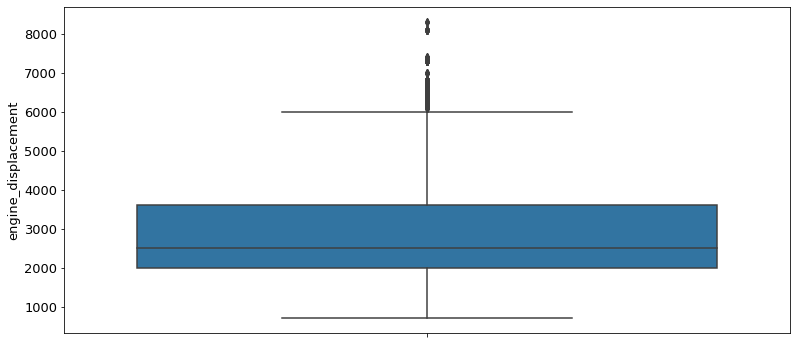

In [51]:
sns.boxplot(y=df.engine_displacement)

---

In [ ]:
df.drop(columns=[
    'vin',
    'back_legroom',
    'daysonmarket',
    'dealer_zip',
    'description',
    'engine_cylinders',
    'engine_type',
    'exterior_color',
    'front_legroom',
    ''
])

---

In [31]:
# df.fuel_tank_volume.astype('object')

In [32]:
df.fuel_tank_volume.dtype

dtype('O')

In [33]:
# df.fuel_tank_volume.apply(find_space)

In [34]:
def pull_out_numbers(string):
    new_string = ''
    for char in string:
        if char.isnumeric():
            new_string += char
    return new_string

In [35]:
def find_space(string):
    for i, char in enumerate(string):
        if char == ' ':
            marker = i
    return string[:marker]

In [36]:
find_space('12.4 gal')

'12.4'

In [37]:
pull_out_numbers('123asdfs65')

'12365'